# Chronos: Learning the Language of Time Series

Learning the `Language of Time Series`, the authors propose a framework for zero-shot `probabilistic forecasting` that leverages existing transformer-based language model architectures. It can `minimally` adapt existing language models for forecasting tasks.

## Motivation
This is not the first time that we try to adapt NLP technologies to time series forecasting.

After all, in both fields, models attempt to learn a sequence of data to predict the next token, whether that token is a word or a number.

However, in NLP, there are a `fixed number of words` to choose from, whereas in time series, it is technically unbounded; **your series can increase or decrease indefinitely**.

## Overview
There are thress main steps in Chronos to adapt LLMs for forecasting.

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*ibIlIE9vE5rbK35vGVIyPQ.png" style="width: 800px;">


### Tokenization of Times Series

Chronos scales and then quantizes the observations into a fixed number of bins.

There are many techniques for scaling data, such as min-max scaling, mean scaling and standard scaling. Here, the authors used mean scaling, which follows the simple formula:

<img src="https://miro.medium.com/v2/resize:fit:572/format:webp/1*u_ZkYha7U17YpRoKwFgY5A.png" style="width: 300px;">

Where m is set to 0, and s is the mean of the absolute values of the series.

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*Iy8OuzjJV1xKYcCma_kqOg.png" style="width: 400px;">

### KernelSynth
To further extend their training set, the authors also propose KernelSynth, a method to generate synthetic time series using Gaussian processes as shown below.

<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*_Vq4BFTnRcFkmjWHP2e6Ow.png" style="width=500px;">

In the figure above, we can see that the linear kernel is combined with itself using a multiplication, resulting in a quadratic shape. Then, that is combined again with the periodic kernel, using addition, adding a seasonal pattern.

From there, the kernel is fed to a Gaussian process, which takes care of generating samples within a certain distribution.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

### Mean scaling

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/medium_views_published_holidays.csv')
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


In [3]:
def mean_scaling(x):
    mean = np.mean(np.abs(x))

    return x/mean

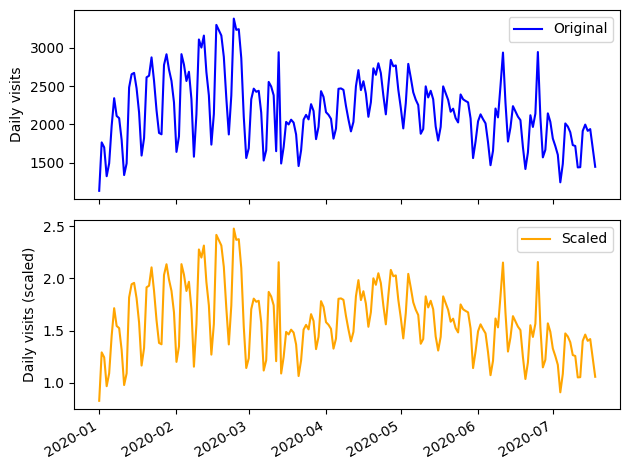

In [4]:
y = df['y'].values
y_scaled = mean_scaling(y)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(df['ds'][:200], y[:200], color='blue', label='Original')
ax1.set_ylabel('Daily visits')
ax1.legend()

ax2.plot(df['ds'][:200], y_scaled[:200], color='orange', label='Scaled')
ax2.set_ylabel('Daily visits (scaled)')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()

### Quantization

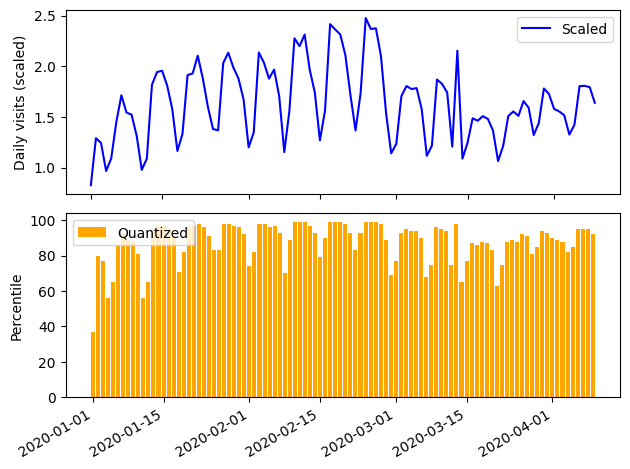

In [5]:
bins = pd.qcut(y_scaled, q=100, labels=False)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(df['ds'][:100], y_scaled[:100], color='blue', label='Scaled')
ax1.set_ylabel('Daily visits (scaled)')
ax1.legend()

ax2.bar(df['ds'][:100], bins[:100], color='orange', label='Quantized')
ax2.set_ylabel('Percentile')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()

In [6]:
%pip install git+https://github.com/amazon-science/chronos-forecasting.git@mlx

  Cloning https://github.com/amazon-science/chronos-forecasting.git (to revision mlx) to /private/var/folders/1m/pswlhn1n1gv1c0lymv7l947r0000gn/T/pip-req-build-lky21vel
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/1m/pswlhn1n1gv1c0lymv7l947r0000gn/T/pip-req-build-lky21vel
  Running command git checkout -b mlx --track origin/mlx
  Switched to a new branch 'mlx'
  branch 'mlx' set up to track 'origin/mlx'.
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 5242d986f48ee2b26b08a3ab8c92ce3b50ccad23
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [7]:
import time
from datasetsforecast.m3 import M3
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate
import torch
from chronos_mlx import ChronosPipeline

In [8]:
Y_df, *_ = M3.load(directory='./', group='Monthly')
Y_df.head(3)

/Users/martinfabbri/Workspace/github/crypto-quant-lab/.venv/lib/python3.11/site-packages/datasetsforecast/m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)


,unique_id,ds,y
0,M1,1990-01-31,2640.0
1,M1,1990-02-28,2640.0
2,M1,1990-03-31,2160.0


In [9]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    dtype="bfloat16",
)

horizon = 12
batch_size = 12


actual = []
chronos_tiny_preds = []

start = time.time()
all_timeseries = [
    sub_df["y"].values[:-horizon]
    for _, sub_df in Y_df.groupby("unique_id")
]
for i in tqdm(range(0, len(all_timeseries), batch_size)):
    batch_context = all_timeseries[i : i + batch_size]
    forecast = pipeline.predict(batch_context, horizon)
    predictions = np.quantile(forecast, 0.5, axis=1)

    chronos_tiny_preds.append(predictions)

chronos_tiny_preds = np.concatenate(chronos_tiny_preds)
chronos_tiny_duration = time.time() - start
print(chronos_tiny_duration)

  0%|          | 0/119 [00:00<?, ?it/s]

8.874199867248535


In [13]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    dtype="bfloat16",
)

horizon = 12
batch_size = 12


actual = []
chronos_large_preds = []

start = time.time()
all_timeseries = [
    sub_df["y"].values[:-horizon]
    for _, sub_df in Y_df.groupby("unique_id")
]
for i in tqdm(range(0, len(all_timeseries), batch_size)):
    batch_context = all_timeseries[i : i + batch_size]
    forecast = pipeline.predict(batch_context, horizon)
    predictions = np.quantile(forecast, 0.5, axis=1)

    chronos_large_preds.append(predictions)

chronos_large_preds = np.concatenate(chronos_large_preds)
chronos_large_duration = time.time() - start
print(chronos_large_duration)

  0%|          | 0/119 [00:00<?, ?it/s]

492.5914030075073


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

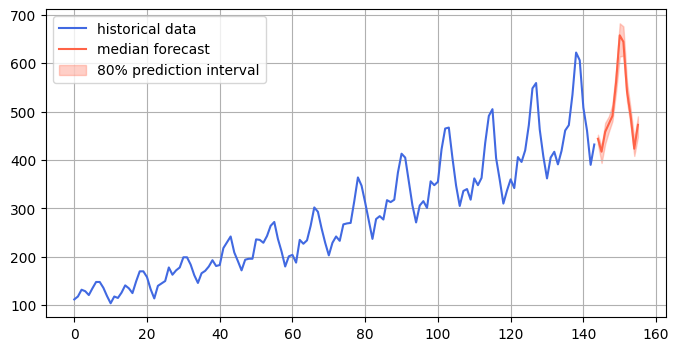

In [1]:
# for plotting, run: pip install pandas matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chronos_mlx import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    dtype="bfloat16",
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = df["#Passengers"].values
prediction_length = 12
forecast = pipeline.predict(
    context,
    prediction_length,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0], [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()